# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import model
import cv2

# TODO #1: Define a transform to pre-process the testing images.
transform_test = model.get_inference_transform()

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [22]:
def load_next_image():
    _, image = next(iter(data_loader))
    image = transform_test(image)
    return image.numpy()

In [23]:
image = load_next_image()
print(type(image))
print(image.shape)

<class 'numpy.ndarray'>
(1, 3, 480, 480)


Run the code cell below to visualize an example test image, before pre-processing is applied.

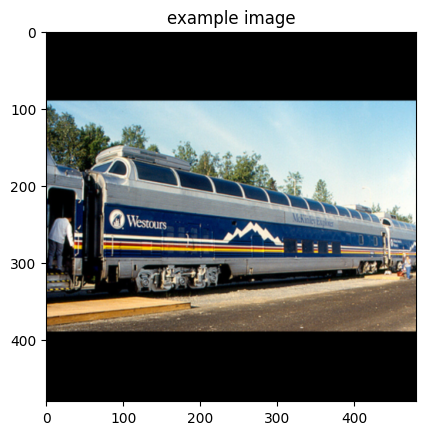

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
image = load_next_image()
# Visualize sample image, before pre-processing.
plt.imshow(np.moveaxis(np.squeeze(image[0]),0,2))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [25]:
# Watch for any changes in model.py, and re-load it automatically.
# % load_ext autoreload
# % autoreload 2

from inference import load_model, load_vocab

model, gflops, weightsMBMem, blobMBMem = load_model("best.onnx")

print("Model resources diagnostics:")
print("Operations:", gflops, "GFLOPS")
print("Total Memory:", weightsMBMem+blobMBMem, "MB")

vocab = load_vocab("simple_vocab.pkl")




Model resources diagnostics:
Operations: 315.007570262 GFLOPS
Total Memory: 2434.878136 MB


<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [26]:
from inference import infer_model

image = load_next_image()

output, time = infer_model(image,model)

print('example output:', output)
print("processing time: ", time, "s" )

example output: [[0.000e+00 3.000e+00 1.672e+03 3.240e+02 3.800e+01 3.000e+00 2.034e+03
  3.800e+01 2.330e+02 1.200e+01 1.000e+00 1.000e+00 1.000e+00 1.600e+01
  2.151e+03 2.130e+02 3.000e+00 1.714e+03 1.200e+01 1.000e+00 1.000e+00
  1.600e+01 3.000e+00 2.670e+02 1.200e+01 1.000e+00 1.000e+00 1.200e+01
  1.000e+00 1.000e+00 1.200e+01 1.000e+00 1.000e+00 1.600e+01 3.000e+00
  1.110e+02 3.400e+01 3.240e+02 3.800e+01 9.000e+00 5.820e+02 1.200e+01
  1.000e+00 1.000e+00 1.600e+01 2.000e+00 1.200e+01 1.000e+00 1.000e+00
  1.600e+01 2.000e+00 1.200e+01 1.000e+00 1.000e+00 1.600e+01 9.000e+00
  4.260e+02 5.090e+02]]
processing time:  0.3662855625152588 s



<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [28]:
# TODO #4: Complete the function.
from inference import translate_tokens

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

example sentence: a zebra standing in a fenced in area.


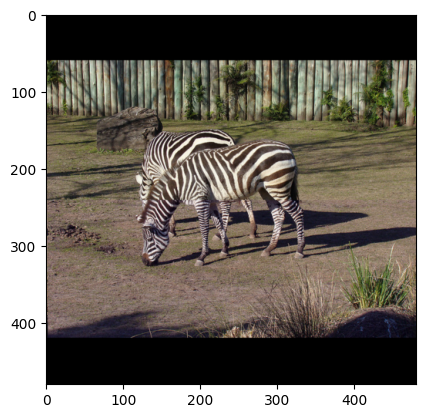

In [32]:
sentence = translate_tokens(output, vocab)[0]
print('example sentence:', sentence)
plt.imshow(np.moveaxis(np.squeeze(image[0]),0,2))
assert type(sentence)==str, 'Sentence needs to be a Python string!'

<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [35]:
def get_prediction():
    image = load_next_image()
    plt.imshow(np.moveaxis(np.squeeze(image[0]),0,2))
    plt.title('Sample Image')
    plt.show()
    
    print(image.shape)
    output, time = infer_model(image,model)
    sentence = translate_tokens(output, vocab)[0]
    
    print(sentence)
    print("processing time", time, "s")

Run the code cell below (multiple times, if you like!) to test how this function works.

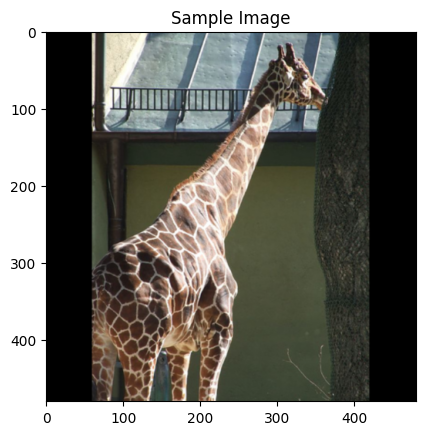

(1, 3, 480, 480)
a giraffe standing next to a stone wall.
processing time 0.2130873203277588 s


In [36]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

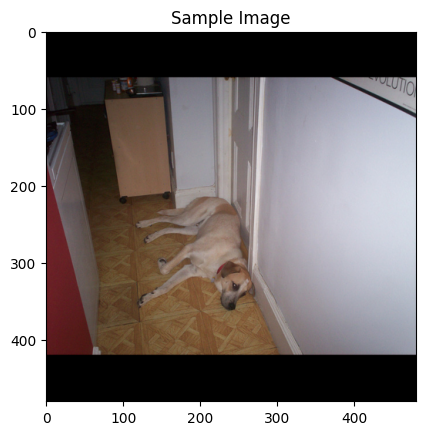

(1, 3, 480, 480)
a dog is standing on a skateboard in the hallway.
processing time 0.19291377067565918 s


In [37]:
get_prediction()

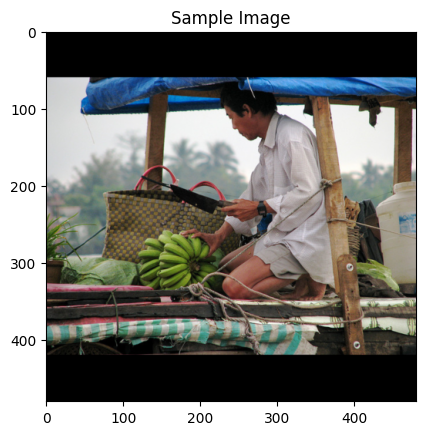

(1, 3, 480, 480)
a man is sitting on a bench with a bunch of bananas.
processing time 0.20354175567626953 s


In [38]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

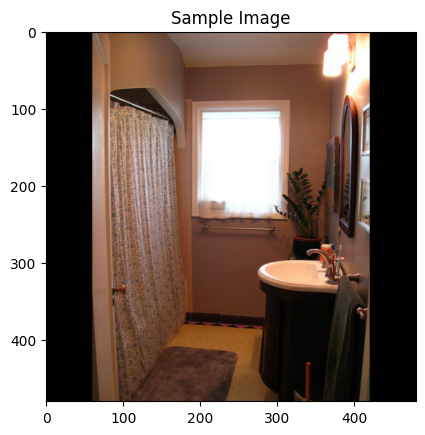

(1, 3, 480, 480)
a bathroom with a sink, toilet and mirror.
processing time 0.20228362083435059 s


In [39]:
get_prediction()

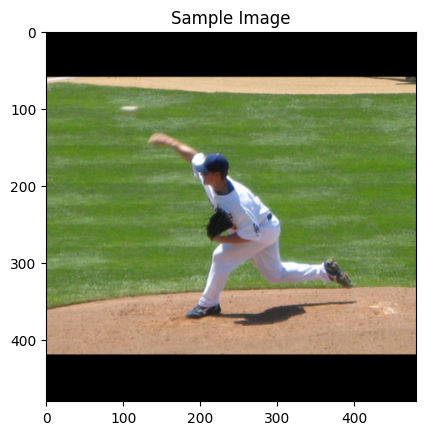

(1, 3, 480, 480)
a baseball player is swinging at a ball.
processing time 0.2160487174987793 s


In [40]:
get_prediction()

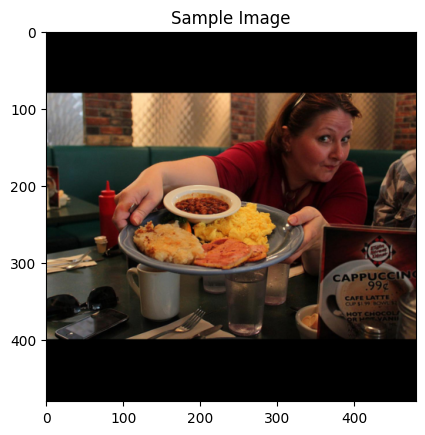

(1, 3, 480, 480)
a woman sitting at a table with a plate of food.
processing time 0.1869213581085205 s


In [41]:
get_prediction()

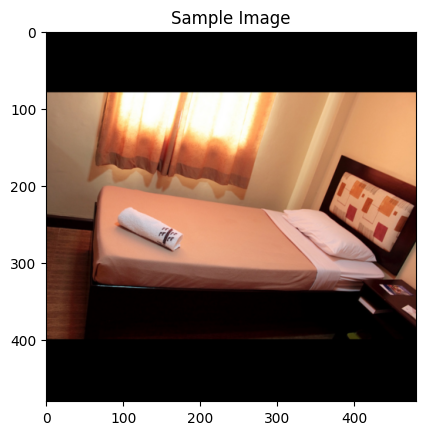

(1, 3, 480, 480)
a bed with a white comforter and pillows on it.
processing time 0.21324586868286133 s


In [42]:
get_prediction()